In [1]:
from adam import ADAM
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap
import numpy as np
from qiskit.quantum_info import Statevector
from math import log

import matplotlib.pyplot as plt

In [2]:
file1 = 'x1_trainData.npy'
x1_train = np.load(file1, allow_pickle=True)

In [3]:
x1_train.shape

(50, 2)

In [4]:
file2 = 'x2_trainData.npy'
x2_train = np.load(file1, allow_pickle=True)

In [5]:
x2_train.shape

(50, 2)

In [7]:
# size of training data set
training_size = 100
# dimension of data sets
n = 2
#from sklearn import datasets
#from sklearn import preprocessing
#iris = datasets.load_iris()
# load iris and normalise
#x = preprocessing.normalize(iris.data)
#x1_train = x[0:49, :] # class A
#x2_train = x[50:99, :] # class B
training_input = {'A':x1_train, 'B':x2_train}
class_labels = ['A', 'B']

In [8]:
sv = Statevector.from_label('0' * n)

In [11]:
def final_circuit(circuit, data, params):
    for i in range(n):
        circuit.h(i)
        circuit.rz(data[i],i)
        circuit.ry(params[i], i)
    circuit.cx(0,1)
    for i in range(n):
        circuit.rz(data[i],i)
        circuit.ry(params[i+2], i)

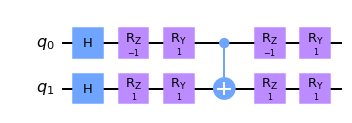

In [12]:
cir = QuantumCircuit(2)
final_circuit(cir, [-1,1],[1,1,1,1])
cir.draw('mpl')

In [13]:
def assign_label(bit_string, class_labels):
    hamming_weight = sum([int(k) for k in list(bit_string)])
    is_odd_parity = hamming_weight & 1
    if is_odd_parity:
        return class_labels[1]
    else:
        return class_labels[0]

def return_probabilities(counts, class_labels):
    shots = sum(counts.values())
    result = {class_labels[0]: 0,
              class_labels[1]: 0}
    for key, item in counts.items():
        label = assign_label(key, class_labels)
        result[label] += counts[key]/shots
    return result

def classify(x_list, params, class_labels):
    qc_list = []
    for x in x_list:
        circuit = QuantumCircuit(n)
        circ_ = final_circuit(circuit, x, params)
        qc = sv.evolve(circuit)
        qc_list += [qc]
    probs = []
    for qc in qc_list:
        counts = qc.probabilities_dict()
        prob = return_probabilities(counts, class_labels)
        probs += [prob]
    return probs


def CrossEntropy(yHat, y):
    if y == 'A':
      return -log(yHat['A'])
    else:
      return -log(1-yHat['A'])


def cost_function(training_input, class_labels, params, shots=100, print_value=False):
    # map training input to list of labels and list of samples
    cost = 0
    training_labels = []
    training_samples = []
    for label, samples in training_input.items():
        for sample in samples:
            training_labels += [label]
            training_samples += [sample]

    # classify all samples
    probs = classify(training_samples, params, class_labels)

    # evaluate costs for all classified samples
    for i, prob in enumerate(probs):
        cost += CrossEntropy(yHat=prob, y=training_labels[i])
    cost /= len(training_samples)

    # return objective value
    #print(cost)
    return cost


# setup the optimizer
optimizer = ADAM(maxiter=100, lr=0.1)

# define objective function for training
objective_function = lambda params: cost_function(training_input, class_labels, params, print_value=True)

d = 4  # num of trainable params
for i in range(100):
    np.random.seed(i)
    # randomly initialize the parameters
    init_params = np.random.uniform(-1,1,d)
    print(init_params)
    # train classifier
    #init_params = np.random.uniform(-1,1,2)
    opt_params, value, _, loss = optimizer.optimize(len(init_params), objective_function, initial_point=init_params)
    print(loss)
    print(opt_params)
    # print results
    f1 = 'quantum_loss_easy_layer2random_%d.npy' %i
    f2 = 'opt_params_easy_layer2random_%d.npy'%i
    np.save(f2, opt_params)
    np.save(f1, loss)

[0.09762701 0.43037873 0.20552675 0.08976637]
[0.7059465147554492, 0.6956177463278523, 0.7018969128868849, 0.7089876220086846, 0.709386834050096, 0.7051845101043668, 0.7000327142475976, 0.6965165784425893, 0.6956340849123052, 0.6968599623418854, 0.6987303517934932, 0.6998013333520018, 0.6994132023194385, 0.6978271433918352, 0.6958582100328482, 0.6943669915205767, 0.693855180400605, 0.6942802292531676, 0.695144649039775, 0.6958144756437352, 0.6958752914897964, 0.695308315375823, 0.6944227946135804, 0.6936397583646241, 0.6932646032504356, 0.693351052289372, 0.6937090127934796, 0.6940428661498721, 0.6941331421606576, 0.6939473586649525, 0.69362213941739, 0.6933496090095836, 0.6932534396912206, 0.6933291384451876, 0.6934723361726169, 0.6935622759094343, 0.6935393210630443, 0.693430495179618, 0.6933165824525404, 0.6932694352480911, 0.6933034742307365, 0.6933726015577626, 0.6934105206941631, 0.6933812866627471, 0.6933020282974938, 0.6932248159057434, 0.6931954516920577, 0.6932210875551666, 0

[0.7447870646130661, 0.7298084378130199, 0.7174853944212265, 0.708159840030322, 0.7020635523742963, 0.6981523310315595, 0.6955964677810921, 0.6945009287971401, 0.6939962803672611, 0.693643284041221, 0.6937982032332047, 0.6939996450338617, 0.6940823956832739, 0.6943481567533629, 0.6944975762582949, 0.6945035125596922, 0.6946212579409456, 0.6946457091990115, 0.6945667772117736, 0.6945702276043266, 0.694509952966386, 0.6943857176744143, 0.6943335013525913, 0.6942387739205685, 0.6941096559260913, 0.69404343498688, 0.6939469933203871, 0.6938389968762158, 0.6937824433331841, 0.6937005060003798, 0.6936247853512796, 0.6935866573541983, 0.6935252649688795, 0.6934808125088692, 0.6934574171476625, 0.6934159988437534, 0.6933965486761103, 0.6933811466638573, 0.6933549462051879, 0.6933481122161395, 0.6933337597789846, 0.693318403023871, 0.6933138138781818, 0.693297903125339, 0.6932884274638558, 0.6932798249594617, 0.6932644983760846, 0.693257129621691, 0.6932446099720286, 0.6932335200230151, 0.69322

[0.8654081670085175, 0.8111336459241016, 0.7669245502475163, 0.7372871659002278, 0.7244305803016293, 0.7262128812177554, 0.7355552853029897, 0.7433548813596605, 0.7437831929481443, 0.7365247575266217, 0.7248761400047664, 0.7129598095780755, 0.7039397991569589, 0.6993002755594298, 0.6988714709161878, 0.7013323240910523, 0.7049046056774241, 0.7079699922962042, 0.7094553428941923, 0.7089652681876661, 0.7067227429515497, 0.703396252370271, 0.6998733812775734, 0.697016266548792, 0.6954286661222225, 0.6952815289122373, 0.6962629692047935, 0.6977037352322856, 0.6988540487076998, 0.6991897000849326, 0.6985936418546126, 0.6973372675315465, 0.6959035306819898, 0.6947609645902584, 0.6941902798868986, 0.6942162205626028, 0.6946462216281287, 0.6951800802572465, 0.6955381776947909, 0.695559417011978, 0.6952397582936424, 0.6947079225498821, 0.6941570600085027, 0.6937624756437544, 0.6936159388438327, 0.6936995203559176, 0.6939062313233575, 0.6940960039895309, 0.6941599371594855, 0.6940631472833261, 0.

[0.7249573401872186, 0.709422695072766, 0.7014997181414313, 0.699302872574374, 0.6999499425574668, 0.7013309297674977, 0.7022312495865997, 0.7021394047458073, 0.7011317622182908, 0.6995861589841358, 0.6979152568202536, 0.6964311973648667, 0.6953160920473341, 0.694640984165911, 0.6943943875725189, 0.6945035623271975, 0.6948453620163471, 0.6952562653355102, 0.6955567508523598, 0.6955985502791279, 0.6953211432199546, 0.6947854381522961, 0.694157263405841, 0.6936401340254755, 0.6933864663610944, 0.6934293430654163, 0.6936692750632758, 0.6939273916802777, 0.6940398782770962, 0.6939412977648307, 0.6936890898911705, 0.6934195863570786, 0.6932656744009891, 0.6932838216259518, 0.6934297229291212, 0.6935933115091517, 0.6936687909221216, 0.6936144995779892, 0.6934680451896839, 0.6933135134178999, 0.6932262927866709, 0.693229697617388, 0.6932881396026169, 0.6933382949175937, 0.6933348705866051, 0.6932783381145797, 0.6932075045863878, 0.6931671898145622, 0.6931763610507552, 0.6932182842488267, 0.69

[0.7203759136418403, 0.7080895366158301, 0.7077338667356153, 0.7119800500366431, 0.714245355438043, 0.7127139015097829, 0.7085334443445955, 0.7034775759949905, 0.6990484732223834, 0.6962107816873911, 0.6952624982098008, 0.6957889491357256, 0.6968731839867475, 0.6976062244319818, 0.6975430082797512, 0.6967748818648569, 0.6957117868399659, 0.6948141824770745, 0.6943962675988249, 0.6945295387465305, 0.6950484014759816, 0.6956462507272412, 0.6960181968498652, 0.6959855457935014, 0.6955491421731935, 0.6948622543702612, 0.6941514839333327, 0.6936229494920493, 0.6933872535139369, 0.6934279714523488, 0.693625651586823, 0.6938250449102408, 0.6939099798578664, 0.6938473716310688, 0.6936844619358707, 0.6935100458875353, 0.6934043665027577, 0.6934014264519156, 0.6934781933172619, 0.693572734613292, 0.6936198767198875, 0.6935846944079518, 0.6934769039280069, 0.693341243569864, 0.6932313350766666, 0.6931824551702607, 0.693196572799799, 0.6932460650148639, 0.6932921578440839, 0.6933067474780735, 0.69

[0.7943437561070202, 0.768960979966954, 0.7466540770259439, 0.7281580251519476, 0.7140298210253735, 0.7046007610588331, 0.6993900090880197, 0.6969740315486839, 0.6958421897498158, 0.6953196149514151, 0.6954537086377007, 0.6962789798785937, 0.6973848035546446, 0.6981829548242819, 0.6984604253242458, 0.6984722883630587, 0.6985181771896245, 0.6985577601626898, 0.6983192510887978, 0.6977301787419908, 0.6970524697524545, 0.6965615132535032, 0.6962288769237917, 0.695834448035889, 0.6953280993482693, 0.6948923293370955, 0.6946532265346227, 0.6945080733791835, 0.6943114220736041, 0.6940926080470269, 0.6939698999327076, 0.6939430884856777, 0.6939001417593568, 0.6937963415916774, 0.6937033580298525, 0.6936761508055264, 0.6936699377421925, 0.6936230188505719, 0.6935505228930781, 0.693505014752668, 0.6934888857695062, 0.6934600399019808, 0.6934052422770531, 0.6933560401173622, 0.6933327428175211, 0.6933151777197811, 0.6932812638962949, 0.693242221690181, 0.6932197906079832, 0.6932108049619725, 0.6

[0.8130920142899207, 0.780136101916626, 0.7618357714976329, 0.7505694337140014, 0.7418862867396621, 0.7342044946827726, 0.7272309982746537, 0.7210185433645282, 0.7156320528498725, 0.7110668809988411, 0.7072493439359904, 0.7040709271999853, 0.7014363083385843, 0.6992977669495992, 0.6976473977929115, 0.6964659530375625, 0.695667570963137, 0.6950997987318803, 0.6946194783716508, 0.6941792957494672, 0.6938316676924515, 0.6936395815197878, 0.6935813441041796, 0.6935520919237568, 0.6934668556622947, 0.6933419954491099, 0.6932582542370792, 0.6932568111363825, 0.6932920502429831, 0.6932919753991998, 0.6932448419009382, 0.6932028791899728, 0.6932082310836225, 0.6932405271174776, 0.6932497177126735, 0.6932238250853211, 0.6931986841317361, 0.6932041469662111, 0.6932255971332654, 0.6932298824826304, 0.6932125897238152, 0.6931995598256333, 0.693206819847024, 0.6932196750942545, 0.693217855336562, 0.6932052006397349, 0.6932004355614947, 0.6932078254446492, 0.6932131920197506, 0.6932076545519509, 0.6

[0.7374024805089617, 0.7236762415605914, 0.7128921688066537, 0.7047959018483826, 0.6992309553832307, 0.6958488440657454, 0.6941549115974703, 0.6935966915451385, 0.6938035644441746, 0.6941931153418314, 0.6948828077377333, 0.6953331325551538, 0.6958043824894041, 0.6960312985192237, 0.69608886966769, 0.6960793887073632, 0.6958604290934721, 0.6956351827362814, 0.6953562311583703, 0.6950280670083534, 0.6947664653328421, 0.6944800338856535, 0.6942298188757698, 0.6940395503950039, 0.6938431737990908, 0.6937025247458238, 0.6935872573667596, 0.6934749530880511, 0.6934086548864516, 0.693343839882466, 0.6932913961228823, 0.6932658241692958, 0.6932329165974278, 0.6932176677107412, 0.6932091573703947, 0.6931946395272298, 0.6931943690146006, 0.6931875264377879, 0.6931815669458331, 0.6931808688463333, 0.6931720624163747, 0.6931697086427471, 0.6931650007684401, 0.6931591350964668, 0.6931586720716951, 0.6931542392967179, 0.6931544610490996, 0.6931541897593644, 0.6931532697102908, 0.6931552302465234, 0.

[0.923973893541244, 0.8280079293484736, 0.765696221846674, 0.7302906320287406, 0.7128918470704199, 0.706555419612617, 0.7074854466928621, 0.7132396530058844, 0.721588906705039, 0.7303095605631051, 0.7373827694895988, 0.7413173067988752, 0.7414323122098704, 0.7379349702529459, 0.7317241144015589, 0.7240404032898499, 0.7161298340127117, 0.7090080306721214, 0.7033379712166122, 0.6994085797973442, 0.6971915060222067, 0.6964415591971924, 0.6968004886231292, 0.6978755899827779, 0.699288577521321, 0.7007054165713668, 0.7018581379214252, 0.7025627403923574, 0.7027293379532833, 0.7023606525612294, 0.7015370944311011, 0.7003918923499589, 0.6990823224371616, 0.6977630674186447, 0.6965660026583087, 0.6955873991279578, 0.6948821310060047, 0.6944637488374693, 0.6943087931993511, 0.6943644441508491, 0.69455842961843, 0.6948100709881525, 0.6950419676741343, 0.6951910311772926, 0.695217191899645, 0.6951081873808049, 0.6948790120124692, 0.6945663669900519, 0.6942190944768808, 0.6938872441081239, 0.69361

[0.8938778505157546, 0.8536353963129819, 0.8272556175418936, 0.8094681566602349, 0.7948922890914446, 0.78092826969687, 0.7672283059740245, 0.7543099450979802, 0.742777008584766, 0.7330152873047989, 0.7250897698044855, 0.7187560810041357, 0.713585866997748, 0.7091834317145822, 0.7053869122764107, 0.7023183367089267, 0.70023434668525, 0.6992553714372662, 0.6991420785184869, 0.6993197800408032, 0.6992020302475456, 0.698556923749031, 0.6976031185001021, 0.6968017706421586, 0.6965202869499039, 0.6967735891636445, 0.6972177474662888, 0.6974266118572491, 0.6972174337773438, 0.6967411227898307, 0.6963115108898372, 0.6961521562306042, 0.6962442868678729, 0.696372204289985, 0.6963206896991285, 0.6960492666965531, 0.6956976422883315, 0.6954450537634388, 0.6953611782883103, 0.6953687420117831, 0.6953306255567661, 0.695170737518449, 0.6949239278849462, 0.6946888631785231, 0.6945398956143959, 0.6944728474699062, 0.6944225700167198, 0.6943281839353223, 0.6941840638206809, 0.6940351158770638, 0.693929

[0.7552451644909699, 0.7351920781481424, 0.7239057810334302, 0.7146617983623054, 0.7068386325739037, 0.7020689295684993, 0.7010275558892498, 0.7024749041828816, 0.7042956617484825, 0.705181092450138, 0.7051415910156988, 0.7048147973035239, 0.7045571102107272, 0.7040727846071636, 0.7028591047569174, 0.7008999694545482, 0.698770533179673, 0.6971417091854526, 0.6962141215515384, 0.6955928219328075, 0.6948036715369942, 0.6938777567918095, 0.6932719084499399, 0.6932845484904471, 0.6936817691586584, 0.6939787507312927, 0.6940051052258316, 0.6940037322220234, 0.6942139959036632, 0.694527366384265, 0.6946460778043705, 0.694492559503589, 0.6942809672930003, 0.6942008717461556, 0.6941819263834303, 0.6940441911985983, 0.693785509981788, 0.6935780785831821, 0.6935117390254715, 0.6934834206330884, 0.6933829436139061, 0.6932629605243426, 0.6932336709991582, 0.6932791767021907, 0.69329338822011, 0.6932556020491085, 0.6932451643052973, 0.6932914591802267, 0.6933273458523934, 0.6933113927825033, 0.6932

[0.7243327037430961, 0.7109667543172824, 0.7095225476716708, 0.7080198467646008, 0.7036202390152602, 0.69958276506198, 0.6987128066462234, 0.7007898149343683, 0.7031363859786807, 0.7035360187283453, 0.702021138672739, 0.7000488971482599, 0.698924726839861, 0.6988124404180399, 0.6988433556226683, 0.6981911321483796, 0.6969173543319394, 0.6957552328699343, 0.695314234570247, 0.6955201048303937, 0.6957578478455284, 0.6955354836987074, 0.694921266566938, 0.6943596469307597, 0.6941902083890272, 0.6943541594291485, 0.6945113852284868, 0.6944039996669744, 0.6940776233687788, 0.6937759640999501, 0.6936782900851414, 0.6937483462316415, 0.6938083475794721, 0.6937307953218931, 0.6935477650647102, 0.693391441159406, 0.6933527791189477, 0.6934019666287378, 0.6934354104248125, 0.693387010402801, 0.6932858264840549, 0.6932119804098689, 0.6932098322525071, 0.6932497238664297, 0.6932688778758395, 0.6932394746177981, 0.6931909289441357, 0.6931700761047201, 0.6931893270740601, 0.6932184388884042, 0.69322

[0.7946542175083221, 0.7648476045861875, 0.7441688345825911, 0.7305640356181294, 0.7218718942925844, 0.7165750592211095, 0.7139268842034042, 0.7131004589016259, 0.712677743955028, 0.7114844310189936, 0.7090241727602913, 0.7053842946456566, 0.7011511013178243, 0.6972865729514564, 0.694877022471718, 0.6946518886334502, 0.6962653884201663, 0.6981076561710249, 0.6986119428676816, 0.697509844856682, 0.6956238269449231, 0.694082382355001, 0.6936580734255651, 0.6943746289465262, 0.6955299092648197, 0.6962250757800291, 0.6960135495921884, 0.6951105230734403, 0.6941324595475283, 0.6936649922185485, 0.6938949548410288, 0.6944994754457925, 0.6949180276443856, 0.6948140461240813, 0.6942982082797541, 0.6937646290811145, 0.693556498684947, 0.6937259682777753, 0.694035121098381, 0.694177332955848, 0.6940261921088597, 0.6937054454000585, 0.6934543192628118, 0.6934239785734263, 0.6935668484697838, 0.6937000608679311, 0.69367895165938, 0.6935157829814016, 0.6933447396243371, 0.6932877194419033, 0.693350

[0.9797010434545741, 0.9141102838212889, 0.8612293614881547, 0.8178313310290379, 0.7813961179265181, 0.7537287687127701, 0.7387765844214934, 0.7386832615674288, 0.7506715733678989, 0.7665314929356464, 0.777120142961196, 0.7778804211231909, 0.7695871420253679, 0.7558442789121115, 0.740685396384503, 0.7272682533347123, 0.717449395537884, 0.7118706910866998, 0.71024945115477, 0.7116581130600502, 0.7147350171793514, 0.7179088657082032, 0.7197219116221004, 0.7192086256135112, 0.7161698742393936, 0.7111993707048159, 0.7054480082339337, 0.7002259398609499, 0.6965842062460823, 0.6950050070023666, 0.6952954921521227, 0.6967221876243752, 0.6983336351602865, 0.69932919859769, 0.6993122175712523, 0.6983415628937222, 0.6968075022873588, 0.6952241823620064, 0.6940323481702647, 0.6934718374602141, 0.6935444950803407, 0.6940584455762927, 0.6947243418950836, 0.695264583081138, 0.6954986360989912, 0.6953812786192547, 0.6949902212636697, 0.6944773797822524, 0.6940065871981719, 0.6936997499982492, 0.69360

[0.7172102813683814, 0.7005548686808283, 0.7043344000901256, 0.712780963969496, 0.714247016398985, 0.7090973766404339, 0.7022330671475282, 0.6978285526999598, 0.6975600464737726, 0.7002673503480381, 0.7031011915230723, 0.7037878046252605, 0.7020253568489687, 0.6991088890023899, 0.696750438587614, 0.696027020890345, 0.6968630085480092, 0.6982490975071879, 0.6990408806354247, 0.6987003094256972, 0.6974746610562093, 0.6960818159847386, 0.6952202795249157, 0.695172282186007, 0.6956882028894004, 0.6962124979304616, 0.6962866480883889, 0.6958286260117041, 0.695116270438087, 0.6945459969777885, 0.6943630745737529, 0.6945307697673847, 0.6947979430073872, 0.6948962138433677, 0.6947181171345506, 0.6943599479213757, 0.6940241203276101, 0.6938684425648161, 0.6939080261894806, 0.6940270001821092, 0.6940784573597414, 0.6939909359114981, 0.6938051405504965, 0.6936261186907199, 0.6935388602855932, 0.6935522517354262, 0.6936057434900806, 0.6936238363349344, 0.6935720065129679, 0.6934739042817624, 0.693

[0.803805275650307, 0.7584391308570966, 0.7248715338213764, 0.7050100980607792, 0.6976639476369982, 0.6987881378930395, 0.7033164168870785, 0.7077526806115769, 0.7106612666796898, 0.7118128767769553, 0.7114722262276956, 0.710040931943597, 0.707906197579493, 0.7053893566637995, 0.702745651136248, 0.7001860413148622, 0.6978976894837443, 0.6960459820944859, 0.6947562697777835, 0.6940865466838143, 0.6940075756584844, 0.6944019453260688, 0.6950848045804142, 0.6958407352539403, 0.6964668456168761, 0.696811428320983, 0.6967999931432531, 0.6964433327898983, 0.6958265363298007, 0.6950819909778638, 0.6943540582954546, 0.6937642594116713, 0.6933864267619227, 0.6932369545152607, 0.6932807468288616, 0.6934486949594718, 0.6936599619223093, 0.6938424931814283, 0.6939471531770951, 0.6939537677488591, 0.6938694973333165, 0.6937217235090298, 0.6935480374490213, 0.6933860428535291, 0.6932650011410699, 0.6932006636500535, 0.6931938136808165, 0.6932322843384359, 0.6932955613856828, 0.6933607239114381, 0.69

[0.6948907057293573, 0.6949729620197891, 0.6991141260835643, 0.6997755178303674, 0.6976248065244296, 0.695061753374262, 0.693670669231397, 0.6937940123401661, 0.6947556924245969, 0.6955638045145556, 0.6956441728483318, 0.6950387216243017, 0.6941551564409039, 0.6934457872130615, 0.693187808740013, 0.6933900683322181, 0.6938300794381737, 0.6942037182197506, 0.6943006119753847, 0.6940948101683719, 0.6937175529132021, 0.6933604818571649, 0.6931736918254575, 0.6932007877796242, 0.6933722623477658, 0.693556388611279, 0.6936378748715732, 0.6935771529941124, 0.6934186677660535, 0.6932532148641475, 0.6931621659339487, 0.693174767774407, 0.6932586970955406, 0.6933463986940177, 0.6933789916533415, 0.6933395078391533, 0.6932564250068647, 0.6931799542462332, 0.6931488720774975, 0.6931690515284222, 0.6932147118046045, 0.6932490314330678, 0.6932487634955098, 0.6932167563806584, 0.693175962297699, 0.6931516567779344, 0.6931545978766488, 0.6931759949310538, 0.6931961632230732, 0.6931994680387886, 0.693

[0.7183188289914813, 0.7148476548445701, 0.7138515723708342, 0.7139137382135727, 0.714682016177888, 0.7145354511782597, 0.7131797720589862, 0.7111312161199705, 0.7085904205224223, 0.7057230045717485, 0.7030756695346292, 0.7010970501082765, 0.6996787035143279, 0.6985587963637743, 0.6976441437585522, 0.696845080959945, 0.6960225889954917, 0.6951171841466801, 0.6942619716219728, 0.6936598749381702, 0.6933639296172509, 0.6933218855628839, 0.6935190686834771, 0.6939043729818211, 0.6943147380641398, 0.6946282405711641, 0.6948303427441789, 0.6949064791709632, 0.6948492845850386, 0.694727789162658, 0.6946099764668431, 0.6944893115528974, 0.694357310468918, 0.6942281184302851, 0.6940817091885192, 0.6938966553288511, 0.6937010406735054, 0.6935198948056521, 0.6933580550267148, 0.6932410528302602, 0.6931827541827303, 0.6931629463851161, 0.6931730364763926, 0.693205940192984, 0.6932378716679805, 0.6932651471508496, 0.6932921914639365, 0.6933108746469095, 0.6933257249514267, 0.6933399449881008, 0.69

[0.716062649153307, 0.7011468399234974, 0.6963526458121659, 0.6970018479897085, 0.6995348277325182, 0.7018046229397847, 0.7027218479750361, 0.702086820289922, 0.7003194288289372, 0.6981127057915198, 0.6961286678895634, 0.6947938778407494, 0.6942234354889858, 0.6942727117693431, 0.6946674911206521, 0.6951349290323927, 0.6954834061001642, 0.6956233236922365, 0.6955489448807777, 0.6953048919251568, 0.6949560916331321, 0.6945683183210006, 0.6941991097702747, 0.693893901354236, 0.6936827007760311, 0.6935759968189718, 0.6935617325419186, 0.6936066050394918, 0.6936637289754216, 0.6936865062519856, 0.6936448052356975, 0.6935371022048771, 0.6933921001749555, 0.6932569657057378, 0.6931763984648935, 0.6931717790314251, 0.6932310214818936, 0.6933149100913201, 0.693377177553171, 0.6933877549478592, 0.693346651987707, 0.6932806469472871, 0.6932254601329223, 0.6932041201592714, 0.6932146612117921, 0.6932346887357326, 0.6932390573475629, 0.6932180231033204, 0.6931826708971279, 0.6931548351366711, 0.69

[0.7809962562936783, 0.7536135605115928, 0.7399456619741294, 0.7332995661498019, 0.7289339706671476, 0.7250709379329056, 0.7213242024489104, 0.7177547407876302, 0.7145660375193801, 0.7119807977200633, 0.7101229847330818, 0.7089188063757372, 0.7081105578505135, 0.7074019676561146, 0.7065892838237002, 0.7055806990896779, 0.7043578189285179, 0.702943229141122, 0.7013880757238035, 0.6997688138295238, 0.6981800622606302, 0.6967185892944062, 0.695464277525398, 0.6944699354951627, 0.6937640935270203, 0.6933572561317001, 0.6932389573764745, 0.6933659413084201, 0.6936558030541423, 0.6940003393777178, 0.6942983703908097, 0.6944902102352511, 0.6945709745663765, 0.694572706036992, 0.6945281410154805, 0.6944445536008432, 0.6943093069418061, 0.6941182052081614, 0.69389546913404, 0.6936849816432893, 0.6935219593258172, 0.6934096797113896, 0.693324594849059, 0.6932466347845745, 0.6931819173141969, 0.6931517084786626, 0.693162351832623, 0.693193613678055, 0.6932194115955042, 0.693234079418443, 0.693251

[0.7144605737384664, 0.7073284800321286, 0.7001084198298706, 0.6972044433356827, 0.6974846595728386, 0.6975641484416887, 0.6973639889111994, 0.6978820477776457, 0.6986432404058606, 0.6983388687312235, 0.6970422892932919, 0.6957993479331313, 0.6951220455024963, 0.6945520664686796, 0.6937746326421409, 0.6932556419188817, 0.6933929887806779, 0.6938461743855473, 0.6940948110098766, 0.6941758227216097, 0.6943927678873217, 0.6946656629022782, 0.6946457101644872, 0.6943459811332943, 0.6940956880786602, 0.693987860304697, 0.693816336815096, 0.6935520142263933, 0.6934196751658415, 0.6934678349889815, 0.6934961592275043, 0.6934529502980139, 0.6934756504307279, 0.6935491567449958, 0.6935239759977211, 0.6934259122735823, 0.6933788910293499, 0.693346418539454, 0.6932546493650699, 0.6931805550916162, 0.6931818911625136, 0.6931839262517869, 0.6931661888511625, 0.6931916817060741, 0.6932366391230859, 0.693241498515046, 0.6932396256775465, 0.6932556202938831, 0.6932455230839405, 0.6932151993794856, 0.6

[0.7202763622638007, 0.703372019875781, 0.696097324560164, 0.6967367347476966, 0.699978388666445, 0.7019349189690373, 0.7017872886485729, 0.7002005579135987, 0.6980987397091506, 0.6961909780455043, 0.6948896795589463, 0.6943607266369521, 0.6945628894084414, 0.6952578845094517, 0.6960708109116521, 0.6966315072234134, 0.6967192613391349, 0.6963206937389137, 0.6955886343847854, 0.6947539477920514, 0.6940397719610469, 0.6935999647609178, 0.6934850290780261, 0.6936373421575719, 0.6939197074369136, 0.6941719820299527, 0.6942744610995369, 0.6941890932089528, 0.693961494331565, 0.6936874242674258, 0.6934626274145629, 0.6933399005095301, 0.6933131710668105, 0.6933350788843562, 0.6933549965365343, 0.6933519883771905, 0.6933403765834606, 0.6933463079102655, 0.6933758316559575, 0.6934035991492847, 0.693394434260433, 0.6933354495003211, 0.6932490660092416, 0.6931775311175055, 0.6931527388310705, 0.6931738518395193, 0.6932108177604338, 0.6932315778391634, 0.6932278279066614, 0.6932150184922641, 0.69

[0.7470377467859524, 0.7156059696741154, 0.703995073851939, 0.7037029793986879, 0.7090125436576921, 0.7155849290548955, 0.7201921688623965, 0.7212826827719944, 0.7188660099561516, 0.7139859749073676, 0.7081468595081529, 0.7028057984706403, 0.6990139216616862, 0.6972351148826681, 0.6973340342593086, 0.6987105152127983, 0.7005348689388115, 0.7020133053739243, 0.7026058198785563, 0.7021370052914834, 0.7007809003360396, 0.6989458004311561, 0.6971099392583046, 0.6956643609280084, 0.694809908788706, 0.6945344040839616, 0.6946661739188761, 0.6949706819137983, 0.6952443179676903, 0.6953673648461671, 0.6953053458434999, 0.6950768659722216, 0.6947220311569076, 0.6942923202818858, 0.6938542766565309, 0.6934859674098521, 0.693257807127577, 0.6932059498801246, 0.6933132910104018, 0.6935106491559729, 0.6937023900268785, 0.6938067584666832, 0.6937890048969351, 0.6936692956516007, 0.69350425290565, 0.6933560955427225, 0.693266115025643, 0.6932437665311213, 0.6932729284661647, 0.6933272130158048, 0.693

[0.7337990383219831, 0.7103495948934512, 0.7016943301835797, 0.7042842461585616, 0.7113163027684389, 0.7147969126401976, 0.7126164059613553, 0.7073756582588692, 0.7024567694165791, 0.6998112848143323, 0.6995149893362678, 0.7005094715100639, 0.7015171731161901, 0.7016304305865054, 0.7006007094989848, 0.6988143693665498, 0.6969972208867773, 0.695812526392362, 0.6955479827747492, 0.6960358954488428, 0.6968181827945823, 0.6974059414523751, 0.6974713001497327, 0.6969299370583939, 0.6959399277977418, 0.6948305582341113, 0.6939705121349475, 0.6936130366033454, 0.6937845889367316, 0.6942797882867745, 0.6947746319463246, 0.6949956168838242, 0.6948451287486719, 0.6944194079212427, 0.6939274536005215, 0.6935689675532928, 0.6934386698296975, 0.6935001249281791, 0.6936321340498247, 0.6937115811657831, 0.6936810356858818, 0.6935660505127114, 0.6934417058332148, 0.6933762060668721, 0.6933875426228445, 0.6934377170222963, 0.6934644204853445, 0.693426437243765, 0.6933311994647995, 0.6932270460373302, 0

[0.7689095060183279, 0.7526483054921603, 0.7407373587010214, 0.7315259398118679, 0.7246946252533678, 0.7195416325479066, 0.7154415109042246, 0.7122498101726858, 0.7100500912027377, 0.7088519427111051, 0.7084500138086645, 0.7084408899317326, 0.7083652327914828, 0.7078824631164725, 0.706873821615705, 0.7054320958262593, 0.7037611466627922, 0.7020461486852709, 0.7003788183374638, 0.6987885308768701, 0.6973280678877096, 0.6961080293663534, 0.6952473475773039, 0.6947872421459159, 0.6946437632515411, 0.6946504159392768, 0.6946636325153247, 0.6946327757032351, 0.6945813586360313, 0.6945384047549084, 0.69448982377483, 0.694388213398484, 0.6942046174112114, 0.6939649971897685, 0.6937318825144132, 0.6935522747900853, 0.6934260154921753, 0.6933243308204627, 0.6932324706963054, 0.6931670249601197, 0.6931525862093408, 0.6931888681102835, 0.6932464239703836, 0.6932940417521867, 0.6933240478630104, 0.6933477906909405, 0.6933719292433809, 0.6933864663709983, 0.693377287308104, 0.6933447192603467, 0.69

In [21]:
loss_eqnn_d1 = np.load('Data/2Layers/Layer2Easy/quantum_loss_easy_layer2random_1.npy')

In [22]:
loss_eqnn_d1.shape

(100,)

In [23]:
loss = np.zeros((100,100))
for i in range(100):
    file = 'Data/2Layers/Layer2Easy/quantum_loss_easy_layer2random_%d.npy'%i
    loss[i] += np.load(file, allow_pickle=True)

In [24]:
loss.shape

(100, 100)

Text(0.5, 1.0, 'Training - 2 Layer (Data Reuploading, Qubits = 2, Easy Model)')

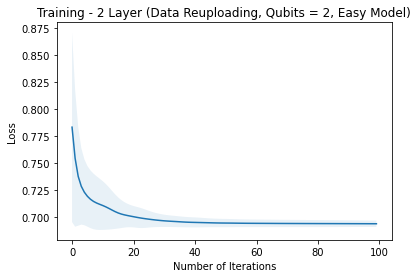

In [25]:
import matplotlib.pyplot as plt
groen = np.array([0,208,0])/255
stddevs =[]
averages =[]
sd = np.std(loss, axis=0)
av = np.average(loss, axis=0)
plt.plot(range(100), av)
plt.fill_between(range(100), av+np.array(sd), av-np.array(sd), alpha=0.1)
stddevs.append(sd)
averages.append(av)

plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.title("Training - 2 Layer (Data Reuploading, Qubits = 2, Easy Model)")